# Back Testing Statistics
Chapter 6 of the book: "Build Your Own AI Investor"

In [ ]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2020
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

In [ ]:
from platform import python_version
print(python_version())

In [1]:
import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [2]:
# X AND Y (no splitting for train/test)
# Financial ratios 
x=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
# annual stock performances
y=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", index_col=0)
# convert to date
y["Date"], y["Date2"]=pd.to_datetime(y["Date"]), pd.to_datetime(y["Date2"])

# X AND Y (splitting for train/test)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", index_col=0)
y_=pd.DataFrame()
y_=y.loc[y_test.index.values, :]

# convert string to datetime
y_["Date"], y_["Date2"]=pd.to_datetime(y_["Date"]), pd.to_datetime(y_["Date2"])

In [3]:
y_.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
11308,VLGEA,23.430,2011-09-06,3.397350e+05,VLGEA,33.37,2012-09-04,7.775210e+05
7636,NEM,24.025,2014-02-21,5.527504e+08,NEM,25.52,2015-02-23,1.941982e+08
2412,CLFD,13.700,2015-11-25,4.617037e+05,CLFD,19.55,2016-11-25,4.506470e+05
3578,DY,81.190,2017-09-01,5.905135e+07,DY,83.49,2018-09-04,5.703436e+07
6650,LSI,94.060,2015-02-24,1.041348e+07,LSI,106.06,2016-02-24,2.836946e+07


In [4]:
y.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.12,2009-01-05,82690764.0,A,31.21,2010-01-05,93452103.0
1,A,29.60,2009-12-21,93198560.0,A,40.65,2010-12-21,146961945.0
2,A,37.59,2010-12-08,126298641.0,A,36.23,2011-12-08,156607798.0
3,A,33.73,2011-12-16,105332044.0,A,39.98,2012-12-17,138114908.0
4,A,40.58,2012-12-20,154557046.0,A,57.47,2013-12-20,169766380.0


In [5]:
y_train

,Perf
11331,-0.145776
8798,-0.355683
11113,0.057571
10299,0.277778
5274,0.217428
...,...
11964,0.000932
5191,-0.262479
5390,-0.200763
860,0.097179


# Functions
A little different from previous chapter code

In [6]:
# Calculate Altman Z'' scores 1995
def calcZScores(x):
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * x['(CA-CL)/TA']\
    + 3.26 * x['RE/TA']\
    + 6.72 * x['EBIT/TA']\
    + 1.05 * x['Book Equity/TL']
    return Z

In [7]:
# Daily stock price time series for ALL stocks. 5M rows. Some days missing.
def getYRawData():
    daily_stock_prices=pd.read_csv(\
                                   'C:/Users/G50/Stock_Data/SimFin/us-shareprices-daily/us-shareprices-daily.csv',\
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', daily_stock_prices.shape)
    return daily_stock_prices

In [8]:
# backtest data
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (5783997, 11)


In [9]:
def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

In [10]:
def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

In [11]:
def getStockPriceData(ticker, y_, mask, daily_stock_prices, rows):
    date1 = y_[mask][y_[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_[mask][y_[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

In [12]:
def getDataForDateRange(date_Index_New, rows):
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")]) #might be a way to speed this up.
    return WeeklyStockDataRows

In [13]:
def getStockTimeSeries(dateTimeIndex, y_, tickers, mask, daily_stock_prices):
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows=pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data for individual stock
        rows = getStockPriceData(tick, y_, mask, daily_stock_prices, rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new, rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick]=WeeklyStockDataRows["Close"].values
    return stockRet

In [14]:
def getPortfolioRelativeTimeSeries(stockRet):
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [15]:
def getPortTimeSeriesForYear(date_starting, y_, x, daily_stock_prices, ml_model_pipeline):
    # get y dataframe as ticker and ticker performance only
    y = getYPerf(y_)
    # Get performance only for time frame we care about,
    # mask original data using the start date
    mask = y_["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(x[mask])
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(x)
    # 3.75 is approx. B- rating
    zbl = (z['Z score'][mask].reset_index(drop=True) > 3) 
    y_pred_z = y_pred[zbl]
    # Get bool list of top stocks
    bl = (y_pred_z[0] > y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    # See Z scores
    #print(z['Z score'][mask].reset_index(drop=True)[bl & zbl]) 
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[mask].reset_index(drop=True)[bl & zbl]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_,\
                                  ticker_list, mask, daily_stock_prices)
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

In [16]:
def getPortTimeSeries(y_, x, daily_stock_prices, ml_model_pipeline, verbose=True):
    dr=pd.date_range(start='2009-01-01', periods=9, freq='Y') # Date range
    port_perf_all_years = pd.DataFrame()
    ref=1 # relative performance reference.
    for curr_date in dr:
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_, x,\
                                 daily_stock_prices, ml_model_pipeline)
        if verbose:
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        this_year_perf = this_year_perf * ref
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        ref = this_year_perf.iloc[-1]
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Try out a single backtest

In [17]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
pl_linear = pickle.load(open("pl_linear.p", "rb" ))
test = getPortTimeSeries(y_, X_test, daily_stock_prices, pl_linear, verbose=True)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 28.34 %
With stocks: ['SLM' 'SBH' 'ARRS' 'JBHT' 'DISH' 'GRA' 'BMRN']
SLM Performance was: 16.99 %
SBH Performance was: 51.58 %
ARRS Performance was: 16.65 %
JBHT Performance was: 31.58 %
DISH Performance was: 6.95 %
GRA Performance was: 37.98 %
BMRN Performance was: 36.66 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: -27.29 %
With stocks: ['CQP' 'NCMI' 'BZH' 'NAV' 'RSYS' 'INFU' 'PDLI']
CQP Performance was: -20.44 %
NCMI Performance was: -32.66 %
BZH Performance was: -57.63 %
NAV Performance was: -32.03 %
RSYS Performance was: -34.52 %
INFU Performance was: -38.82 %
PDLI Performance was: 25.1 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: 44.63 %
With stocks: ['KATE' 'AJRD' 'UIS' 'SRPT' 'BZH' 'CCXI' 'MITK']
KATE Performance was: 13.69 %
AJRD Performance was: 62.41 %
UIS Performance was: -9.69

# Now loop through model tests and get some statistics to work with.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

In [18]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
        ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# ElasticNet model pipeline
def trainElasticNetModel(X_train, y_train):
    pl_ElasticNet = Pipeline([('Power Transformer', PowerTransformer()),
        ('ElasticNet', ElasticNet(l1_ratio=0.00001))])
    pl_ElasticNet.fit(X_train, y_train)
    return pl_ElasticNet

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
        ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))
    ])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))
    ])
    pl_rfregressor.fit(X_train, y_train)
    
    return pl_rfregressor

# GradientBoostingRegressor
def traingbregressorModel(X_train, y_train):
    pl_GradBregressor = Pipeline([
        ('GradBoostRegressor',\
         GradientBoostingRegressor(n_estimators=100,\
                                   learning_rate=0.1,\
                                   max_depth=10,\
                                   random_state=42,\
                                   loss='ls'))  ])
    pl_GradBregressor.fit(X_train, y_train)
    
    return pl_GradBregressor

# SVM
def trainsvmModel(X_train, y_train):
    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),
        ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))])
    pl_svm.fit(X_train, y_train)
    return pl_svm

## Try and find a good train/test split proportion (rough)

In [19]:
# Y percentage perf
y_pec=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)["Perf"]

In [20]:
y_=y.loc[y_test.index.values, :]

In [23]:
y_

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
11308,VLGEA,23.430,2011-09-06,3.397350e+05,VLGEA,33.37,2012-09-04,7.775210e+05
7636,NEM,24.025,2014-02-21,5.527504e+08,NEM,25.52,2015-02-23,1.941982e+08
2412,CLFD,13.700,2015-11-25,4.617037e+05,CLFD,19.55,2016-11-25,4.506470e+05
3578,DY,81.190,2017-09-01,5.905135e+07,DY,83.49,2018-09-04,5.703436e+07
6650,LSI,94.060,2015-02-24,1.041348e+07,LSI,106.06,2016-02-24,2.836946e+07
...,...,...,...,...,...,...,...,...
2031,CBG,23.870,2013-03-01,8.383383e+07,CBG,27.79,2014-03-03,8.643246e+07
7696,NGVT,77.260,2018-02-28,2.831525e+07,NGVT,114.82,2019-02-28,2.364993e+07
6956,MEET,5.700,2017-03-09,1.202187e+07,MEET,2.58,2018-03-09,6.678320e+06
813,AMZN,371.760,2014-01-31,6.005708e+09,AMZN,350.05,2015-02-02,3.581681e+09


In [32]:
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_GradBregressor', 'pl_rfregressor', 'pl_svm']

for model in model_pipeline_list:
    for myTstSze in [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]:
        X_train, X_test, y_train, y_test = train_test_split(x, y_pec,\
                                                            test_size=myTstSze)
        
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train, y_train)
        if (model =='pl_svm'):
            model_pl = trainsvmModel(X_train, y_train)
        else:
            # Linear mdoel default
            model_pl = trainLinearModel(X_train, y_train) 
            
        y_=y.loc[y_test.index.values, :]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_, X_test,\
                                 daily_stock_prices, model_pl, verbose=False) 
        
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performance:', round(perf, 2), 'Volatility:', round(vol,2),\
              'Model', model, 'Test size: ', myTstSze)

Performance: 3.09 Volatility: 0.55 Model pl_linear Test size:  0.02
Performance: 1.84 Volatility: 0.39 Model pl_linear Test size:  0.1
Performance: 2.07 Volatility: 0.46 Model pl_linear Test size:  0.25
Performance: 4.15 Volatility: 0.77 Model pl_linear Test size:  0.5
Performance: 2.83 Volatility: 0.6 Model pl_linear Test size:  0.75
Performance: 4.64 Volatility: 0.67 Model pl_linear Test size:  0.9
Performance: 2.18 Volatility: 0.44 Model pl_linear Test size:  0.98
Performance: 1.17 Volatility: 0.31 Model pl_KNeighbors Test size:  0.02
Performance: 2.98 Volatility: 0.45 Model pl_KNeighbors Test size:  0.1
Performance: 3.87 Volatility: 0.47 Model pl_KNeighbors Test size:  0.25
Performance: 4.43 Volatility: 0.94 Model pl_KNeighbors Test size:  0.5
Performance: 2.16 Volatility: 0.36 Model pl_KNeighbors Test size:  0.75
Performance: 3.56 Volatility: 0.93 Model pl_KNeighbors Test size:  0.9
Performance: 2.54 Volatility: 0.33 Model pl_KNeighbors Test size:  0.98
Performance: 2.38 Volatilit

## Now getting the backtesting statistics proper
Can take as long as you want, depending on desired accuracy

In [95]:
# Choose the model pipelines to run loop for
#model_pipeline_list = ['pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_linear', 'pl_GradBregressor', 'pl_KNeighbors', 'pl_ElasticNet']
model_pipeline_list = ['pl_KNeighbors']

i, results = 0, []
for model in model_pipeline_list:
    tests_per_model=30
    for test_num in range(0, tests_per_model):
        X_train, X_test, y_train, y_test = train_test_split(x, y_pec,\
                                                            test_size=0.5)
        #Train different models
        if (model =='pl_linear'):
            model_pl = trainLinearModel(X_train, y_train)
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train, y_train)
        if (model =='pl_svm'):
            model_pl = trainsvmModel(X_train, y_train)
        y_=y.loc[y_test.index.values, :]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_, X_test,\
                             daily_stock_prices, model_pl, verbose=False) 
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performed test ',i , [i, model, perf, vol])
        results.append([i, model, perf, vol])
        i=i+1

# Save our results for plotting
results_df = pd.DataFrame(results, columns=["Test Number",\
                                            "Model Used",\
                                            "Indexed Return",\
                                            "Annual Volatility"])
results_df.to_csv("Backtest_statistics_Big.csv")

Performed test  0 [0, 'pl_KNeighbors', 2.2839234461632483, 0.585480877809496]
Performed test  1 [1, 'pl_KNeighbors', 5.560733023713979, 0.997326382903973]
Performed test  2 [2, 'pl_KNeighbors', 2.9197751317509604, 0.5049307337725606]
Performed test  3 [3, 'pl_KNeighbors', 5.572202537471458, 1.0618830978399512]
Performed test  4 [4, 'pl_KNeighbors', 6.2914500161436, 1.2172400607499865]
Performed test  5 [5, 'pl_KNeighbors', 1.281294578902342, 0.33875904031225396]
Performed test  6 [6, 'pl_KNeighbors', 1.2507728492344679, 0.3493431815044925]
Performed test  7 [7, 'pl_KNeighbors', 3.3389460462168423, 0.752925626319227]
Performed test  8 [8, 'pl_KNeighbors', 12.400622686396, 1.7725369651230694]
Performed test  9 [9, 'pl_KNeighbors', 2.082062016543623, 0.6588398091854956]
Performed test  10 [10, 'pl_KNeighbors', 3.57376350934693, 0.730779699282298]
Performed test  11 [11, 'pl_KNeighbors', 2.7070251731583324, 0.6116380858574333]
Performed test  12 [12, 'pl_KNeighbors', 1.7287221481839772, 0.

In [96]:
results_df = pd.read_csv('Backtest_statistics_Big.csv', index_col=0)

# Investigating Backtest Statistics

In [97]:
def plotBacktestDist(results_df, model_file, col):
    ax=results_df[results_df['Model Used']==model_file][col].hist(\
                                    bins=50, density=True, alpha=0.7)
    
    ax2=results_df[results_df['Model Used']==model_file][col].plot.kde(\
                                    alpha=0.9)
    
    max_val=results_df[results_df['Model Used']==model_file][col].max()
    ax.set_xlabel(col)
    ax.set_ylabel('Normalised Frequency')
    ax.set_title('{} Backtest Distribution for {}, {} Runs'.format(\
          col,\
          model_file,\
          results_df[results_df['Model Used']==model_file][col].size))
    ax.grid()
    mean=results_df[results_df['Model Used']==model_file][col].mean()
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns
        ax.plot([2.340448, 2.340448], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='g', linestyle='-', linewidth=1.5, alpha=1)
        plt.xlim(0, 10)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility
        ax.plot([0.3093181642834542, 0.3093181642834542], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='g', linestyle='-', linewidth=2)  
        plt.xlim(0, 1.5)
    ax.legend(['Fitted Smooth Kernel','S&P500 Benchmark', \
               'Simulation Mean {}'.format(round(mean,2)),\
               'Simulation Backtests'])

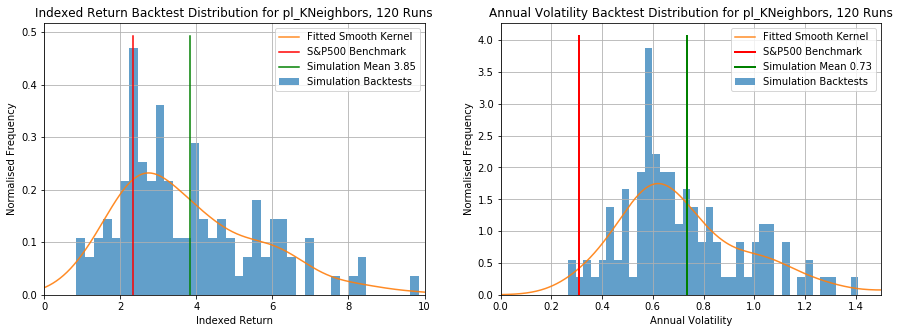

In [98]:
model_file = 'pl_KNeighbors'#['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors']
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')
plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

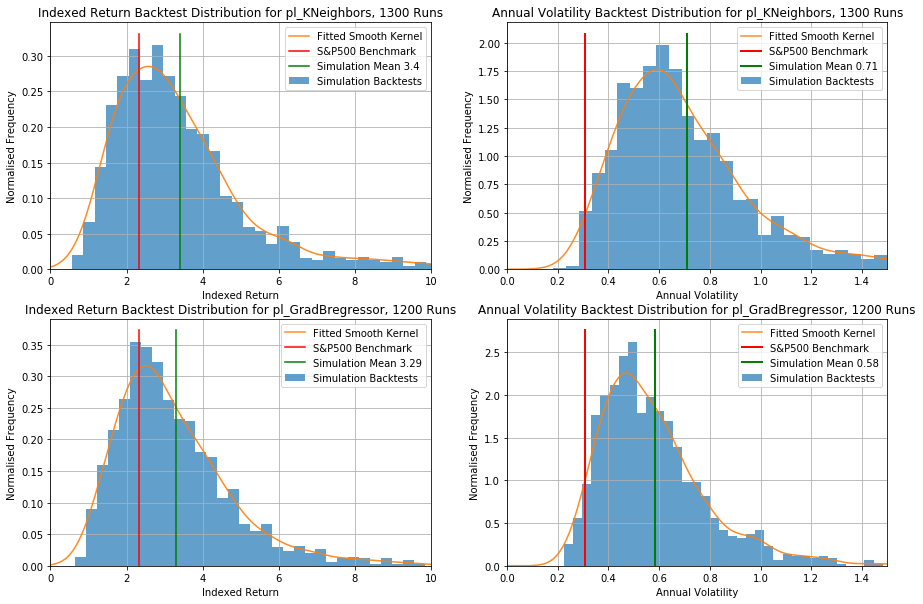

In [109]:
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
model_file = ['pl_KNeighbors', 'pl_GradBregressor']
numPlots = len(model_file)
plt.figure(figsize=(15,5*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Chosen Regressors for AI are Random Forest and KNN

We will expect more volatility, but a good change of greater returns

Text(0.5, 1.0, 'KNN Backtest Return vs. Volatility')

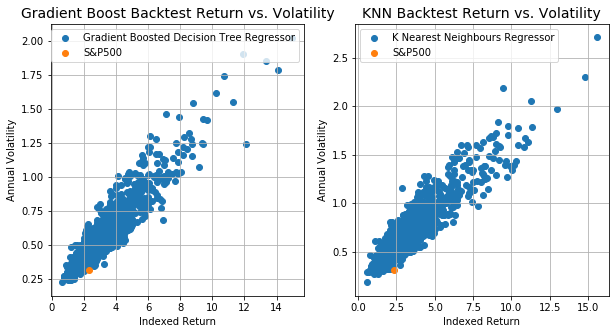

In [114]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility']
plt.scatter(returns, vols)
plt.scatter(2.340448, 0.309318)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['Gradient Boosted Decision Tree Regressor', 'S&P500'])
plt.title('Gradient Boost Backtest Return vs. Volatility', fontsize=14)

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility']
plt.scatter(returns, vols)
plt.scatter(2.340448, 0.309318)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['K Nearest Neighbours Regressor', 'S&P500'])
plt.title('KNN Backtest Return vs. Volatility', fontsize=14)

Text(0.5, 0, 'Annual Volatility')

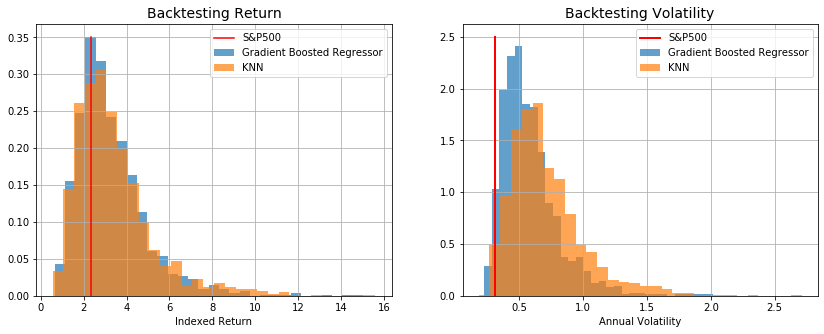

In [124]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([2.340448, 2.340448], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Return', fontsize=14)
plt.xlabel('Indexed Return')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([0.3093181642834542, 0.3093181642834542], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Volatility', fontsize=14)
plt.xlabel('Annual Volatility')

# Figure out what the actual performance should be

In [99]:
# Choose the model pipelines to run loop for
model_pipeline_list = ['pl_GradBregressor', 'pl_KNeighbors']
tests_per_model=20

# Reduce test size and check performance to try and see a trend
# Is effectively *0.5 as test size is 1/2 of total data.
test_size_modifier_list = [0.8, 0.6, 0.4, 0.2, 0.1]

# Results DataFrame
results_df = pd.DataFrame( columns=["Test Number",\
                                            "Model Used",\
                                            "Test Set Size",\
                                            "Indexed Return",\
                                            "Annual Volatility"])

i, results = 0, []
for model in model_pipeline_list:
    for test_size_mod in test_size_modifier_list:
        for test_num in range(0, tests_per_model):
            
            X_train, X_test, y_train, y_test = \
            train_test_split(x, y_pec, test_size=0.5)
            
            new_test_size = round(len(X_test)//(1/test_size_mod))
            
            X_test, y_test = \
            X_test[:new_test_size], y_test[:new_test_size]
            
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            y_=y.loc[y_test.index.values, :]

            # Here is our backtesting code
            test = getPortTimeSeries(\
             y_, X_test,daily_stock_prices, model_pl, verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            #print('Performed test ',i , [i, model, new_test_size, perf, vol])     
            
            results_df=results_df.append(\
                        pd.DataFrame(\
                             [[i, model, new_test_size, perf, vol]],\
                                     columns=results_df.keys()))      
            i=i+1
            
        print('For {} test size {}, Performance: {}, Vol: {}.'.format(\
              model, new_test_size, \
            results_df['Indexed Return'].tail(tests_per_model).mean(),\
            results_df['Annual Volatility'].tail(tests_per_model).mean()))

# Save our results for plotting
results_df.to_csv("Backtest_statistics_Modified_test_size.csv")

For pl_GradBregressor Config: test size 4835, Performance: 3.025541899289832, Vol: 0.5360121598799191.
For pl_GradBregressor Config: test size 3626, Performance: 2.8011500473479276, Vol: 0.5307238149141102.
For pl_GradBregressor Config: test size 2417, Performance: 3.5153269951732034, Vol: 0.557104578945058.
For pl_GradBregressor Config: test size 1208, Performance: 2.9742892470885436, Vol: 0.5137796428307545.
For pl_GradBregressor Config: test size 604, Performance: 3.0614757048587147, Vol: 0.4783925153719483.
For pl_KNeighbors Config: test size 4835, Performance: 3.4182809392564564, Vol: 0.6847220791505033.
For pl_KNeighbors Config: test size 3626, Performance: 3.356844772878514, Vol: 0.7045594978744443.
For pl_KNeighbors Config: test size 2417, Performance: 2.5994868503617665, Vol: 0.5417653915575019.
For pl_KNeighbors Config: test size 1208, Performance: 2.4542562066474662, Vol: 0.48768102691640847.
For pl_KNeighbors Config: test size 604, Performance: 2.8523880397185324, Vol: 0.45

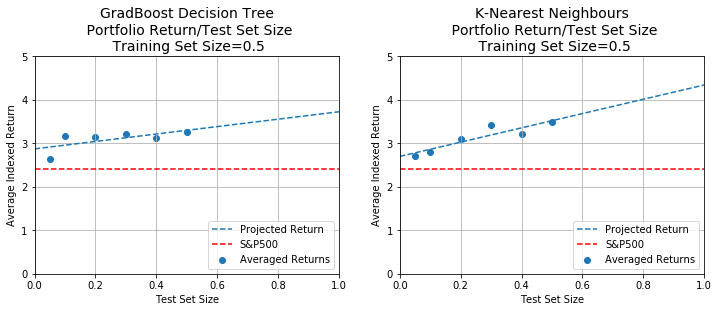

In [90]:
test_set_size = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
gradB_avgReturn = [3.27, 3.12, 3.21, 3.15, 3.16, 2.65]
knn_avgReturn = [3.48, 3.21, 3.43, 3.11, 2.81, 2.7]



plt.figure(figsize=(12,4))

linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(gradB_avgReturn).reshape(-1,1))
plt.subplot(1,2,1)
plt.scatter(test_set_size, gradB_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 5])
plt.title('GradBoost Decision Tree\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'--')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(knn_avgReturn).reshape(-1,1))
plt.subplot(1,2,2)
plt.scatter(test_set_size, knn_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 5])
plt.title('K-Nearest Neighbours\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'--')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


# Final Stock Selection for 2020 with Gradient Boosted Decision Tree and K Nearest Neighbours

In [132]:
def pickStockForMe():
    # Training X and Y of all previous year data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", index_col=0)
    # annual stock performances
    yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)
    yperf=yperf["Perf"]

    # Stock selection ratios for 2020 X
    X_2020=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_2020.csv", index_col=0)
    # And the row tickers
    tickers=pd.read_csv("Tickers_Dates_2020.csv", index_col=0)
    
    # Gradient Boosted tree
#     model_pl = traingbregressorModel(X, yperf)
#     y_pred=model_pl.predict(X_2020)
#     y_pred=pd.DataFrame(y_pred)
    
    # KNN
    model_pl = trainKNeighborsModel(X, yperf)
    y_pred=model_pl.predict(X_2020)
    y_pred=pd.DataFrame(y_pred)

    # FINAL STOCK PICKS
    # Separate out stocks with low Z scores
    # 3.75 is approx. B- rating
    z = calcZScores(X_2020)
    zbl = (z['Z score'].reset_index(drop=True) > 2) 

    # Final_Predictions = pd.DataFrame()
    Final_Predictions = tickers[['Ticker','Date']].reset_index(drop=True)[zbl].reset_index(drop=True)
    Final_Predictions['Perf'] = y_pred.reset_index(drop=True)[zbl].reset_index(drop=True)

    return Final_Predictions.sort_values(by='Perf', ascending=False).head(20)

In [133]:
pickStockForMe()

,Ticker,Date,Perf
859,TRC,2020-03-10,0.944445
733,RCUS,2020-03-05,0.880830
235,CVSI,2020-03-30,0.724740
770,SCWX,2020-03-27,0.596616
783,SHO,2020-02-19,0.590744
101,AXL,2020-02-14,0.536063
390,GPRE,2020-02-20,0.512001
559,MDB,2020-03-27,0.507434
660,OKTA,2020-03-06,0.485089
888,UBER,2020-03-02,0.454132
